In [1]:
#General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from IPython.display import clear_output
import time

#Own code
from utils.data_utils import create_data, create_dgp_data, transformation, standardize
from utils.tvp_models import TVPVARModel

# Suppress scientific notation in numpy
np.set_printoptions(suppress=True)

In [2]:
train = 200

M = 3
p = 4
T = train - p
k = M*(M*p+1)

print("k: " + str(k))

np.random.seed(12345)

k: 39


In [3]:
ds = pd.read_csv("data/fred_qd.csv")

In [4]:
transform=True

gdp = transformation(ds["GDPC1"].iloc[2:].to_numpy(), 5, transform)
cpi = transformation(ds["CPIAUCSL"].iloc[2:].to_numpy(), 6, transform)
fedfund = transformation(ds["FEDFUNDS"].iloc[2:].to_numpy(), 2, transform)
compi = transformation(ds["PPIACO"].iloc[2:].to_numpy(), 6, transform)
borrowings = transformation(ds["TOTRESNS"].iloc[2:].to_numpy(), 6, transform)
sp500 = transformation(ds["S&P 500"].iloc[2:].to_numpy(), 5, transform)
m2 = transformation(ds["M2REAL"].iloc[2:].to_numpy(), 5, transform)

series_total = [gdp, cpi, fedfund]
#series_total = [gdp, cpi, fedfund, compi, borrowings , sp500, m2]

In [5]:
standardized_series = standardize(series_total, train)

In [6]:
# Create matrices from FED-QD
X, y = create_data(standardized_series, train, T, M, p, k)

In [7]:
# # SVSS
# tvp_svss = TVPVARModel(X, y, p, train)
# mt1t_svss, St1t_svss = tvp_svss.train(print_status=False)

# # Horseshoe
# tvp_horseshoe = TVPVARModel(X, y, p, train)
# tvp_horseshoe.initialize_priors(prior='horseshoe')
# mt1t_horseshoe, St1t_horseshoe = tvp_horseshoe.train(print_status=False)

# # Lasso
# tvp_lasso = TVPVARModel(X, y, p, train)
# tvp_lasso = tvp_lasso.initialize_priors(prior='lasso')
# mt1t_lasso, St1t_lasso = tvp_horseshoe.train(print_status=False)

In [8]:
complete_T = cpi.shape[0]
X_complete, y_complete = create_data(standardized_series, complete_T, complete_T-p, M, p, k)

In [9]:
tvp_svss = TVPVARModel(X_complete, y_complete, p, train)
mt1t_svss, St1t_svss = tvp_svss.train(print_status=False)

/Users/cavriends/Dropbox/ESE/MSc Econometrics/Thesis/Bayesian VARs/Code/Jupyter/utils/tvp_models.py:193: RuntimeWarning: divide by zero encountered in true_divide
  gamma         = 1/(np.multiply(1+(np.divide((1-self.pi0),self.pi0)),np.exp(l_0-l_1)))
/Users/cavriends/Dropbox/ESE/MSc Econometrics/Thesis/Bayesian VARs/Code/Jupyter/utils/tvp_models.py:193: RuntimeWarning: invalid value encountered in true_divide
  gamma         = 1/(np.multiply(1+(np.divide((1-self.pi0),self.pi0)),np.exp(l_0-l_1)))


In [10]:
X_complete.shape

(241, 3, 39)

In [10]:
tvp_lasso = TVPVARModel(X_complete, y_complete, p, train)
tvp_lasso.initialize_priors(prior='lasso')
mt1t_svss, St1t_lasso = tvp_svss.train(print_status=False)

In [11]:
predictions = tvp_lasso.calculate_predictions(8)

In [12]:
predictions[:,1,0]

array([-3.53513188, -2.92632848, -1.04133431, -0.27563902, -0.15220033,
       -0.32116318, -0.65861147, -0.95111289, -0.5208667 ,  0.00740126,
        0.07572175, -0.02868685, -0.21736079, -0.26070537, -0.48923686,
       -0.61031047, -0.51944212, -0.55143365, -0.95811173, -0.8461438 ,
       -0.58026532, -0.51076458, -0.3393177 , -0.45314824, -0.77911839,
       -1.58977969, -1.30372307, -0.53778145, -0.96935614, -1.11474887,
       -0.72813409, -0.49806457, -0.49102479, -0.34961137, -0.71219652,
       -0.93841291, -0.42362866, -0.26037767, -0.38457675, -0.49160859,
       -0.72390698, -0.96825284, -0.61017943, -0.44257724, -0.49954756])

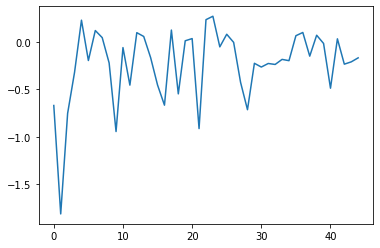

In [13]:
plt.plot(predictions[:,0,0])

In [14]:
np.mean((predictions[:,0,0] - y_complete[196:,0])**2)

0.4635476502323241

In [22]:
y_pred = np.empty((T,M))

for m in range(M):

    for t in range(T):

        y_pred[t,m] = X[t,m,:]@mt1t_svss[:,t]

In [9]:
def calculate_predictions(total_h, current_X, mt1t):

    prev_X = current_X

    prev_pred = np.zeros((M,total_h))

    for h in range(total_h):

        prev_pred[:,h] = prev_X@mt1t[:,-1]
        vec_X = prev_X[0,:(M*p+1)]

        empty_X = np.zeros((M*p+1))
        empty_X[0] = 1

        for m in range(M):
            empty_X[(m*p+2):((m+1)*p+1)] = vec_X[(m*p+1):((m+1)*p)]

        vec_X = empty_X
        vec_X[1::p] = prev_pred[:,h]

        prev_X = np.zeros((M,k))
        for m in range(M):
            total_lags = M*p+1
            prev_X[m,m*(total_lags):(m+1)*total_lags] = vec_X

    return prev_pred

In [2]:
def calculate_msfe(X_complete, y_complete, p, train_begin=200, complete_T=243, total_h=8, prior='svss', prior_parameters={'tau_0':0.1, 'tau_1':10, 'pi0':0.5} ,homoskedastic=True):

    y_pred = np.zeros((complete_T-train_begin,M,total_h))
    counter = 0
    MSFE_TVP = np.zeros(total_h)
    for idx, t in enumerate(range(train_begin, complete_T)):

        train_T = t-p
        X_train = X_complete[:train_T]
        y_train = y_complete[:train_T]
        counter += 1
        mt1t, St1t = tvp_var_vb(X_train, y_train, train_T, M, p, k, prior=prior, homoskedastic=homoskedastic, prior_parameters=prior_parameters, prior_default=False, print_status=False)

        y_pred[idx] = calculate_predictions(total_h, X_complete[train_T], mt1t)
    
    for h in range(total_h):
        if h == 0:
            MSFE_TVP[h] = np.mean((y_complete[train_begin-p:]-y_pred[:,:,0])**2)
        else:
            MSFE_TVP[h] = np.mean((y_complete[train_begin-p+h:]-y_pred[:-h,:,h])**2)
            
    return MSFE_TVP

In [12]:
# for h in range(total_h):
#     if h == 0:
#         MSFE_TVP = np.mean((y_complete[train_begin-p:]-y_pred[:,:,0])**2)
#         MSFE_RW = np.mean((y_complete[train_begin-p:]-y_complete[train_begin-p-1:-1])**2)
#     else:
#         MSFE_TVP = np.mean((y_complete[train_begin-p+h:]-y_pred[:-h,:,h])**2)
#         MSFE_RW = np.mean((y_complete[train_begin-p:]-y_complete[train_begin-p-(h+1):-(h+1)])**2)
              
#     print(str(h+1) + "-step ahead" + "\n" + "MSFE TVP-VAR: " + "\t" + str(round(MSFE_TVP,4)) + "\n" + "MSFE RW: " + "\t" + str(round(MSFE_RW,4)) + "\n" + "Ratio: " + str(round(MSFE_TVP/MSFE_RW,4)))

In [13]:
# %%time

# lambda_values = np.arange(50,51,0.5)
# derivative_values = np.zeros(lambda_values.shape[0])
# error = np.sqrt(1.1e-16)

# for idx, lambda_value in enumerate(lambda_values):
                                   
#     derivative_values[idx] = (calculate_msfe(X_complete, y_complete, p, prior='lasso', prior_parameters={'lambda_param':lambda_value+error})[0] - calculate_msfe(X_complete, y_complete, p, prior='lasso', prior_parameters={'lambda_param':lambda_value-error})[0])/(2*error)
#     print(idx)

In [14]:
def insample_msfe(X_complete, y_complete, p, train_begin=200, complete_T=243, total_h=8, prior='svss', prior_parameters={'tau_0':0.1, 'tau_1':10, 'pi0':0.5} ,homoskedastic=True):
    
    M = X_complete.shape[1]
    k = X_complete.shape[2]
    
    train_T = train_begin-p
    X_train = X_complete[:train_T]
    y_train = y_complete[:train_T]
    
    tvp_var = TVPVARModel(X_train, y_train)
    tvp_var.initialize_priors(prior, prior_parameters, False)
    mt1t, St1t = tvp_var.train(print_status=False)
    
    y_pred = np.empty((train_T,M))

    for m in range(M):

        for t in range(train_T):

            y_pred[t,m] = X_train[t,m,:]@mt1t[:,t]
            
    msfe = np.mean((y_pred - y_complete[:train_T])**2)
    
    return msfe

In [13]:
def point_prediction(X_complete, y_complete, p, train_begin=242, complete_T=243, prior='svss', prior_parameters={'tau_0':0.1, 'tau_1':10, 'pi0':0.5} ,homoskedastic=True):
    
    M = X_complete.shape[1]
    k = X_complete.shape[2]
    
    train_T = train_begin-p
    X_train = X_complete[:train_T]
    y_train = y_complete[:train_T]
    
    tvp_var = TVPVARModel(X_train, y_train)
    tvp_var.initialize_priors(prior, prior_parameters, False)
    mt1t, St1t = tvp_var.train(print_status=False)
    
    y_pred = np.empty((train_T,M))

    for m in range(M):

        for t in range(train_T):

            y_pred[t,m] = X_train[t,m,:]@mt1t[:,t]
    
    return y_pred

In [14]:
train_T = 242

X_train = X_complete[:train_T]
y_train = y_complete[:train_T]

tvp_var = TVPVARModel(X_train, y_train)
mt1t, St1t = tvp_var.train(print_status=False)



In [15]:
def point_prediction_full(X_complete, y_complete, p, prior='svss', prior_parameters={'tau_0':0.1, 'tau_1':10, 'pi0':0.5} ,homoskedastic=True):
    
    M = X_complete.shape[1]
    k = X_complete.shape[2] 
    
    X = X_complete[:-1]
    y = y_complete[:-1]
    
    tvp_var = TVPVARModel(X, y)
    tvp_var.initialize_priors(prior, prior_parameters, False)
    mt1t, St1t = tvp_var.train(print_status=False)
    
    pred = np.zeros(M)
    
    for m in range(M):
        pred[m] = X[-1,m,:]@mt1t[:,-1]
        
    return pred

In [19]:
import os

def calculate_derivative (parameter_value):
    error = np.sqrt(1.1e-16)
    derivative = (calculate_msfe(X_complete, y_complete, p, prior='lasso', prior_parameters={'lambda_param':parameter_value+error})[0] - calculate_msfe(X_complete, y_complete, p, prior='lasso', prior_parameters={'lambda_param':parameter_value-error})[0])/(2*error)
    print('lambda: ' + str(parameter_value) + " is done!" + "\n" + "process ID: " + str(os.getpid()))
    return derivative

In [ ]:
%%time
import os
from multiprocessing import Pool, Array

lambda_values = np.arange(50,51,0.20)

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.map(calculate_derivative, lambda_values)

In [ ]:
import pickle

with open('derivatives.pkl', 'wb') as f:
    pickle.dump(derivatives, f, pickle.HIGHEST_PROTOCOL)

In [22]:
def calculate_derivative_insample (parameter_value):
    error = np.sqrt(1.1e-16)
    derivative = (insample_msfe(X_complete, y_complete, p, prior='lasso', prior_parameters={'lambda_param':parameter_value+error}) - insample_msfe(X_complete, y_complete, p, prior='lasso', prior_parameters={'lambda_param':parameter_value-error}))/(2*error)
    return derivative

In [23]:
%%time
import os
from multiprocessing import Pool, Array
from functools import partial

lambda_values = np.arange(50,51,0.025)
print(lambda_values.shape[0])

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.map(calculate_derivative_insample, lambda_values)

40
CPU times: user 79.7 ms, sys: 52.5 ms, total: 132 ms
Wall time: 58.1 s


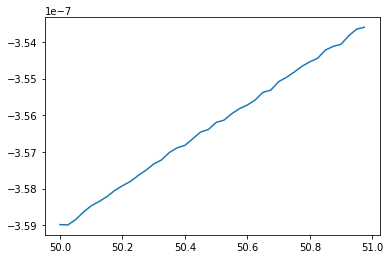

In [24]:
plt.plot(lambda_values, derivatives)

In [16]:
def calculate_derivative_point_gdp(parameter_value):
    error = np.sqrt(1.1e-16)
    derivative = (point_prediction_full(X_complete, y_complete, p, 'lasso', {'lambda_param':parameter_value+error})[0] - point_prediction_full(X_complete, y_complete, p, 'lasso', {'lambda_param':parameter_value-error})[0])/(2*error)
    return derivative

In [18]:
calculate_derivative_point_gdp(50)

-1.722469286023001e-06

In [27]:
%%time
import os
from multiprocessing import Pool, Array
from functools import partial

lambda_values = np.arange(30,400,0.50)
print(lambda_values.shape[0])

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.map(calculate_derivative_point_gdp, lambda_values)

740
CPU times: user 4.16 s, sys: 1.62 s, total: 5.78 s
Wall time: 16min 54s


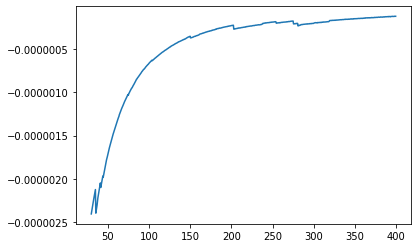

In [28]:
plt.plot(lambda_values, derivatives)

In [26]:
import pickle

with open('derivatives.pkl', 'wb') as f:
    pickle.dump(derivatives, f, pickle.HIGHEST_PROTOCOL)